# Section 1: Homework Exercises

This material provides some hands-on experience using the methods learned from the first day's material. They focus on building models using real-world data.

## Exercise: Rejection Sampling

Sample from the pdf returned by `mixture_of_gaussians` using rejection sampling. We will implement this as a Python generator, and yield the proposed draw, `z`, as well as whether it was accepted. You should assume `proposal_dist` comes from `scipy.stats`, so it has a `.rvs()` method that samples, and a `.pdf` method that evaluates the probability density function at a point.

If $kq(x)$ is not larger than $\tilde{p}(x)$, throw an exception!

The cell below has a plot to check your implementation.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import seaborn as sns

def mixture_of_gaussians():
    rvs = (st.norm(-3, 1), st.norm(0, 1), st.norm(3, 1))
    probs = (0.5, 0.2, 0.3)
    def pdf(x):
        return sum(p * rv.pdf(x) for p, rv in zip(probs, rvs))
    return pdf

def rejection_sampler(pdf, proposal_dist, k):
    """
    Yields proposals, and whether that proposal should be accepted or rejected
    """
    while True:
        z = proposal_dist.rvs()
        # Enter your code below
        ####################
        accept = True
        yield z, accept
        ####################

def gen_samples(draws, sampler):
    """An example of how to use the rejection sampler above."""
    samples = []
    for n_draws, (z, accept) in enumerate(sampler, 1):
        if accept:
            samples.append(z)
            if len(samples) == draws:
                return np.array(samples), n_draws

CPU times: user 153 ms, sys: 18.3 ms, total: 171 ms
Wall time: 160 ms


Text(0.5, 1.0, '10,000 draws from the pdf with 100.00% efficiency')

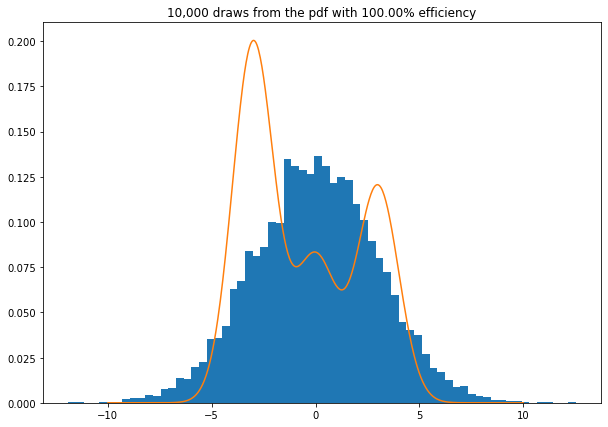

In [2]:
%%time

pdf = mixture_of_gaussians()
proposal_dist = st.norm(0, 3)
k = 3

samples, draws = gen_samples(10_000, rejection_sampler(pdf, proposal_dist, k))

fig, ax = plt.subplots(figsize=(10, 7))

t = np.linspace(-10, 10, 500)

# This histogram should look very similar to the pdf that is plotted
ax.hist(samples, bins='auto', density=True)
ax.plot(t, pdf(t))

ax.set_title(f'{samples.size:,d} draws from the pdf with {100 * samples.size / draws:.2f}% efficiency');

## Exercise: Comparing Two Groups with Binary Outcomes

Binary outcomes are common in clinical research: 

- survival/death
- true/false
- presence/absence
- positive/negative

In practice, binary outcomes are encoded as ones (for event occurrences) and zeros (for non-occurrence). A single binary variable is distributed as a **Bernoulli** random variable:

$$f(x \mid p) = p^{x} (1-p)^{1-x}$$

In terms of inference, we are typically interested in whether $p$ is larger or smaller in one group relative to another.

To demonstrate the comparison of two groups with binary outcomes using Bayesian inference, we will use a sample pediatric dataset. Data on 671 infants with very low (<1600 grams) birth weight from 1981-87 were collected at Duke University Medical Center. Of interest is the relationship between the outcome intra-ventricular hemorrhage (IVH) and predictor such as birth weight, gestational age, presence of pneumothorax and mode of delivery.

In [30]:
vlbw = pd.read_csv('../data/vlbw.csv', index_col=0).dropna(axis=0, subset=['ivh', 'pneumo'])
vlbw.head()

,birth,exit,hospstay,lowph,pltct,race,bwt,gest,inout,twn,...,vent,pneumo,pda,cld,pvh,ivh,ipe,year,sex,dead
5,81.593002,81.598999,2.0,6.969997,54.0,black,925.0,28.0,born at Duke,0.0,...,1.0,1.0,0.0,0.0,definite,definite,NaN,81.594055,female,1
6,81.601997,81.771004,62.0,7.189999,NaN,white,940.0,28.0,born at Duke,0.0,...,1.0,0.0,0.0,0.0,absent,absent,absent,81.602295,female,0
13,81.683998,81.853996,62.0,7.179996,182.0,black,1110.0,28.0,born at Duke,0.0,...,0.0,1.0,0.0,1.0,absent,absent,absent,81.684448,male,0
14,81.689003,81.877998,69.0,7.419998,361.0,white,1180.0,28.0,born at Duke,0.0,...,0.0,0.0,0.0,0.0,absent,absent,absent,81.689880,male,0
16,81.696999,81.952004,93.0,7.239998,255.0,black,770.0,26.0,born at Duke,0.0,...,1.0,0.0,0.0,1.0,absent,absent,absent,81.698120,male,0


To demonstrate binary data analysis, we will try to estimate the difference between the probability of an intra-ventricular hemorrhage for infants with and without a pneumothorax. 

In [31]:
pd.crosstab(vlbw.ivh, vlbw.pneumo)

pneumo,0.0,1.0
ivh,,
absent,359,73
definite,45,30
possible,6,4


We will create a binary outcome by combining `definite` and `possible` into a single outcome.

In [32]:
ivh = vlbw.ivh.isin(['definite', 'possible']).astype(int).values
x = vlbw.pneumo.astype(int).values

Fit a model that evaluates the association of a pneumothorax with the presence of IVH.

In [33]:
# Write your answer here